In [1]:
import pandas as pd
import numpy as np

#Görselleştirme
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud

#cleaning
import re
from bs4 import BeautifulSoup



from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

from sklearn.preprocessing import LabelEncoder


import torch
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification




In [2]:
data =pd.read_csv("data/Clothing/clothingClear.csv")


In [3]:
label_encoder = LabelEncoder()
data['rating_encoded'] = label_encoder.fit_transform(data['rating'])
rating_dict = {idx:str(label) for idx, label in enumerate(label_encoder.classes_)}
rating_dict

{0: '1', 1: '2', 2: '3', 3: '4', 4: '5'}

In [4]:
data.head(3)

,clothingID,review,rating,cleanReview,rating_encoded
0,767,Absolutely wonderful - silky and sexy and comf...,4,absolutely wonderful silky sexy comfortable,3
1,1080,Love this dress! it's sooo pretty. i happene...,5,love dress sooo pretty happen store glad bc on...,4
2,1077,I had such high hopes for this dress and reall...,3,hope dress initially petite usual size outrage...,2


In [5]:
def softClean(review):

    #küçük harf dönüşümü
    review = review.lower()

    #html ayıkla 
    review = BeautifulSoup(review,"html.parser").get_text()

    #yabancı karakter ayıkla
    review= re.sub('[^A-Za-z]'," ",review)
    review = re.sub(r'\s+', ' ', review).strip()
    
    return review 

#data["softReview"]=data["review"].apply(lambda review: softClean(review))

In [6]:
train_texts, val_texts, train_labels, val_labels = train_test_split(data['review'].tolist(), 
                                                                    data['rating_encoded'].tolist(), 
                                                                    test_size=0.2, stratify=data['rating_encoded'].tolist(),
                                                                    random_state=5)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [7]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=256)

In [8]:
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = ReviewDataset(train_encodings, train_labels)
val_dataset = ReviewDataset(val_encodings, val_labels)


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [10]:
#torch.cuda.empty_cache()

In [11]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)
model = model.cuda()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Eğitim argümanları
training_args = TrainingArguments(
    output_dir='/results',
    overwrite_output_dir=True,

    evaluation_strategy="steps", #epoch yap yada steps sayısını küçült batch büyült
    eval_steps=500, # stepte bir doğruklama
   
    do_train=True,
    do_eval=True,

    per_device_train_batch_size=8,  
    per_device_eval_batch_size=8,

    torch_empty_cache_steps=501,  # cuda cache clear
    learning_rate=5e-5,
    weight_decay=0.01,

    num_train_epochs=10,

    warmup_ratio=0.05,

    #log_level="info", #silinebilir
    #logging_strategy steps
    #logging_steps (int or float, optional, defaults to 500
    logging_dir='/logs', 

    load_best_model_at_end=True, 
    save_strategy="steps", #modelin eğitim sırasında checkpoint kaydetme stratejisini 
    save_steps=500,
    save_total_limit=3,

    #restore_callback_states_from_checkpoint=True, #Eğer eğitim sırasında kullanılan callback'lerin (örneğin, eğitim izleme, erken durdurma vb.) durumlarının devam etmesini istiyorsanız kullanabilirsiniz.
    metric_for_best_model="accuracy",  # en iyi modelin belirlenmesinde kullanılan değerlendirme metriğini


                   
)


c:\Users\emrul\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
import numpy as np



def compute_metrics(p):

    pred, labels = p
    pred = np.argmax(pred, axis=-1) 
    
   
    
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    
    precisionMacro = precision_score(labels, pred, average='macro', zero_division=0) 
    precisionWeighted = precision_score(labels, pred, average='weighted', zero_division=0)

    recallMacro = recall_score(labels, pred, average='macro') 
    recallWeighted = recall_score(labels, pred, average='weighted')

    f1Macro = f1_score(labels, pred, average='macro') 
    f1Weighted = f1_score(labels, pred, average='weighted')

    return {
            "accuracy":accuracy,
            "f1-scoreMacro":f1Macro,
            "f1-scoreWeighted":f1Weighted,
            "precisionMacro":precisionMacro,
            "precisionWeighted":precisionWeighted,
            "recallMacro":recallMacro,
            "recallWeighted":recallWeighted
            }


In [ ]:
from transformers import EarlyStoppingCallback
trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,  
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
          
)

trainer.train()

In [15]:
preds = trainer.predict(val_dataset)
pred_labels = torch.argmax(torch.tensor(preds.predictions), axis=1)

print(classification_report(val_labels, pred_labels.tolist(), zero_division=0))

  0%|          | 0/567 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.34      0.54      0.42       164
           1       0.39      0.27      0.32       310
           2       0.48      0.41      0.44       565
           3       0.56      0.37      0.44       982
           4       0.80      0.93      0.86      2508

    accuracy                           0.69      4529
   macro avg       0.51      0.51      0.50      4529
weighted avg       0.66      0.69      0.67      4529



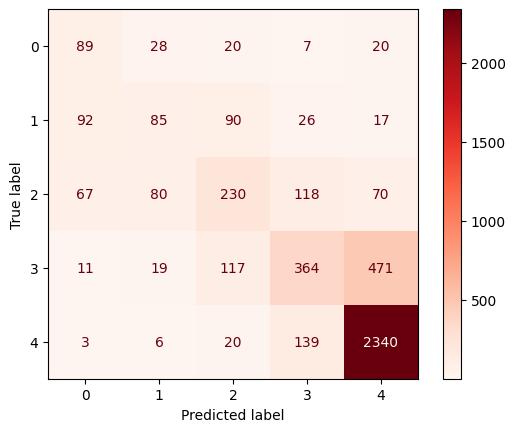

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
cm = confusion_matrix(val_labels, pred_labels.tolist())
class_names = np.unique(val_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Reds')
plt.show()

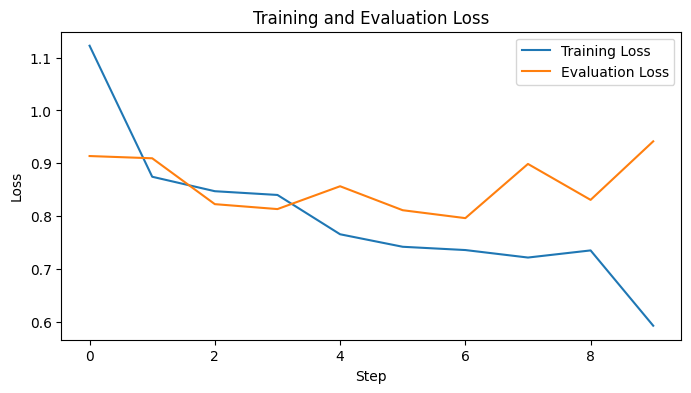

In [ ]:
import matplotlib.pyplot as plt

# Log history 
log_history = trainer.state.log_history


train_loss = [log.get('loss') for log in log_history if 'loss' in log]
eval_loss = [log.get('eval_loss') for log in log_history if 'eval_loss' in log]
auc = [log.get('auc') for log in log_history if 'auc' in log]


if train_loss or eval_loss:  
    plt.figure(figsize=(8, 4))
    if train_loss:
        plt.plot(train_loss, label='Training Loss')
    if eval_loss:
        plt.plot(eval_loss, label='Evaluation Loss')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Training and Evaluation Loss')
    plt.legend()
    plt.show()
else:
    print("No loss data available to plot.")




In [ ]:
#trainer.save_model("models/classificationModels/bert")